<a id="plan"></a>

# Training ML models on the prepared data

1.  [Company and detector specific model](#firstmodel)
    1. [Small version of RandomForestClassifier](#firstsmall)
    2. [Interpretaion of results](#firstsmallinterpret)
    3. [Fitting the whole dataset](#firstbig)
    4. [Interpretation of results: Part I](#firstbiginterpret1)
    5. [Interpretation of results: Part II](#firstbiginterpret2)
    6. [Interpretation of results: Part III](#firstbiginterpret3)
2.  [General model](#secondmodel)
    1. [Optuna study: RandomForestClassifier](#secondstudiesrf)
    2. [Optuna study: XGBClassifier](#secondstudiesxgb)
    3. [Optuna study: CatBoostClassifier](#secondstudiescatb)
    4. [Results of optuna studies](#secondstudiesres)
    5. [Best model I cross-validation](#secondmodelbestxgb)
    6. [Best model I cross-validation results](#secondmodelbestxgbres)
    7. [Best model II cross-validation](#secondmodelbestrf)
    8. [Best model II cross-validation results](#secondmodelbestrfres)
    9. [Addressing problems](#secondwholesamplecvproblem)
    10. [Conclusion on the problem](#secondwholesamplecvproblemconclusion)
    11. [XGBClassifier on a 3M sample](#secondstudiesxgb3m)
    12. [Interpretation of results: Part I](#second3mres1)
    13. [Interpretation of results: Part II](#second3mres2)
    14. [Interpretation of results: Part III](#second3mres3)

In this notebook I am training the main models and interpreting the results obtained

[Bottom](#bottom)

In [1]:
# Machine learning and metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, f1_score,
                            confusion_matrix, roc_curve, precision_recall_curve)
from sklearn.model_selection import cross_val_score, KFold
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import optuna

# Data visualization and manipulation
import numpy as np
import pandas as pd
from scipy.cluster import hierarchy
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
%matplotlib inline

# Other
import dill
from pathlib import Path
import gc
from tqdm import tqdm
import src.prepcatboosting as pcat

# XGBoost warning about mismatched devices that we do not need to worry about
import warnings
warnings.filterwarnings(
    "ignore",
    message=".*Falling back to prediction using DMatrix due to mismatched devices.*"
)

In [2]:
data_path = Path().resolve() / 'data'
models_path = Path().resolve() / 'models'

In [3]:
df_train = pd.read_feather(data_path / 'ready2model.feather')
df_test = pd.read_feather(data_path / 'test_ready2model.feather')

<a id="firstmodel"></a>

## Company and detector-specific model

As one could have noticed from the data preprocessing notebook, I left the `OrgId` and `DetectorId` (which give us information about which company and detector the event comes from). My first hypothesis was: some companies are definitely attacked more frequently that others and some detectors work better then the others. Intuitively it sounds quite logical. The aim of the first ML attempt is to create a model that puts this factors into consideration, therefore we build a company-, detector-specific model, that probably generalizes worse once new companies/detectors are introduced.

<a id="firstsmall"></a>

### Small version of RandomForestClassifier

To understand the starting model, let me build the naive one, so that we have foundation to compare with further tuning. Also, we will start by a sample of `500_000` entries to estimate the needed time to fit the whole dataset.

[Back to top](#plan)

In [4]:
train_sample = df_train.sample(n=500_000, random_state=42)
test_sample = df_test.sample(n=500_000, random_state=42)
X_train = train_sample.drop(columns=['IncidentGrade'])
y_train = train_sample['IncidentGrade']
X_test = test_sample.drop(columns=['IncidentGrade'])
y_test = test_sample['IncidentGrade']

In [5]:
classifier = RandomForestClassifier(random_state=42, n_jobs=-1)

%time classifier.fit(X_train, y_train)

CPU times: total: 1min 41s
Wall time: 13.9 s


RandomForestClassifier(n_jobs=-1, random_state=42)

In [6]:
y_pred = classifier.predict(X_test)

Accuracy Score: 0.9982

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    107221
           1       1.00      1.00      1.00    217528
           2       1.00      1.00      1.00    175251

    accuracy                           1.00    500000
   macro avg       1.00      1.00      1.00    500000
weighted avg       1.00      1.00      1.00    500000



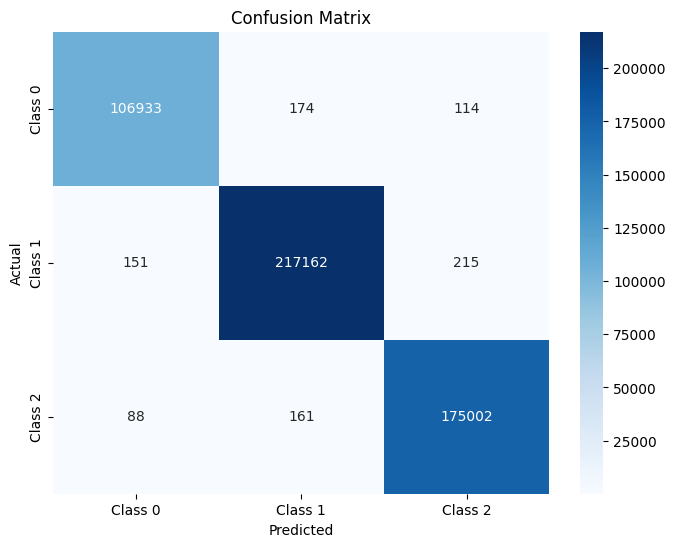

In [7]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<a id="firstsmallinterpret"></a>

### Interpretation of the results we obtained

We are mostly interested in macro F1-score, as we need both: Precision and Recall. As we can see, on a sample of 500_000 all metrics in classification report are equal to 1 (precise up to 2 digits after the comma). The result seems quite artificial, at least unnatural. What are we also interested in is missed Class 2. Of course, other missed classes are also very important, but missing TP may lead to financial/data losses, as the attack was not identified. There we observe very small values, still not 0, but at this point we can`t do anything to tune the model. Moreover, overtuning here will lead to even more overfitting/memorizing the data. Let me try to fit the model on the whole dataset.

<a id="firstbig"></a>

### Fitting the same basic RandomForestClassifier on the whole dataset

[Back to top](#plan)

In [8]:
X_train = df_train.drop(columns=['IncidentGrade'])
y_train = df_train['IncidentGrade']
X_test = df_test.drop(columns=['IncidentGrade'])
y_test = df_test['IncidentGrade']

In [9]:
classifier = RandomForestClassifier(random_state=42, n_jobs=-1)

%time classifier.fit(X_train, y_train)

CPU times: total: 52min 54s
Wall time: 7min 28s


RandomForestClassifier(n_jobs=-1, random_state=42)

In [10]:
y_pred = classifier.predict(X_test)

Accuracy Score: 0.9954

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   2029773
           1       1.00      1.00      1.00   4116515
           2       0.99      1.00      1.00   3304106

    accuracy                           1.00   9450394
   macro avg       1.00      1.00      1.00   9450394
weighted avg       1.00      1.00      1.00   9450394



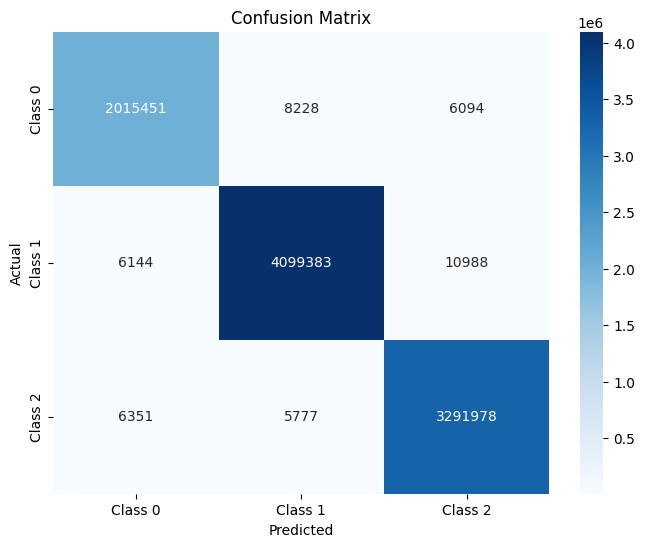

In [11]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<a id="firstbiginterpret1"></a>

### Interpretation of the results we obtained. Part I

We are still interested in macro F1-score. As we can see, on the whole dataset all metrics in classification report are in [0.99, 1] range. The misclassification of Class 2 (the importance of which I have discussed above) is still quite low, here we are happy. What we can worry about are the unnaturally high results in the report. We should remember that:
  1. It is not preprocessing or data splitting problem
  2. We do not have data leakage (we tried our best to escape from it in the preprocessing part)
  3. Train and test sets were obtained from Microsoft separately

Having this said, I am suggesting (and proving it beneath) that our data has the same kind of "distribution" and structure, therefore we have a high result.

[Back to top](#plan)

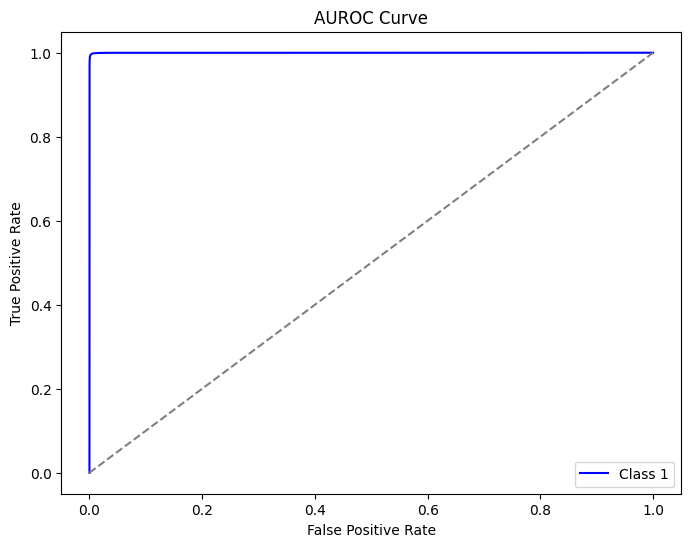

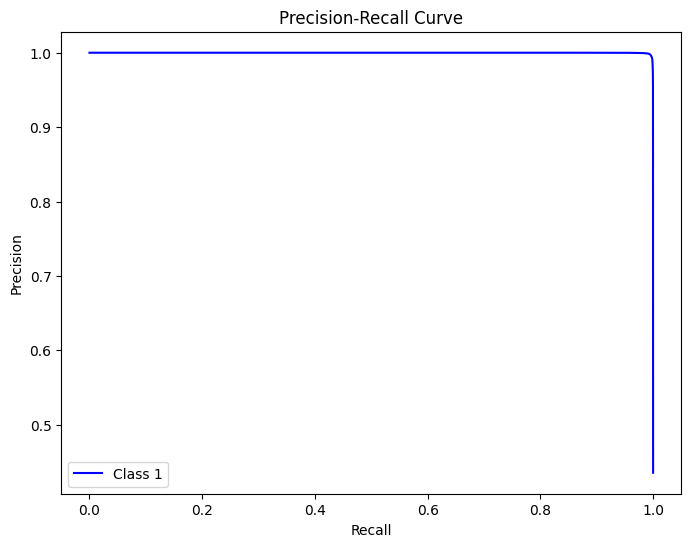

In [12]:
y_prob = classifier.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1], pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label='Class 1')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("AUROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_prob[:, 1], pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label='Class 1')
plt.title("Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

<a id="firstbiginterpret2"></a>

### Interpretation of the results we obtained. Part II

For the sake of interest I plot the ROC-AUC and Precision-Recall curve for one of the classes: Class 1. There is no huge difference up to here for which class to plot the curves: they are equal in results. As suggested, the plots look like "from the textbook".

[Back to top](#plan)

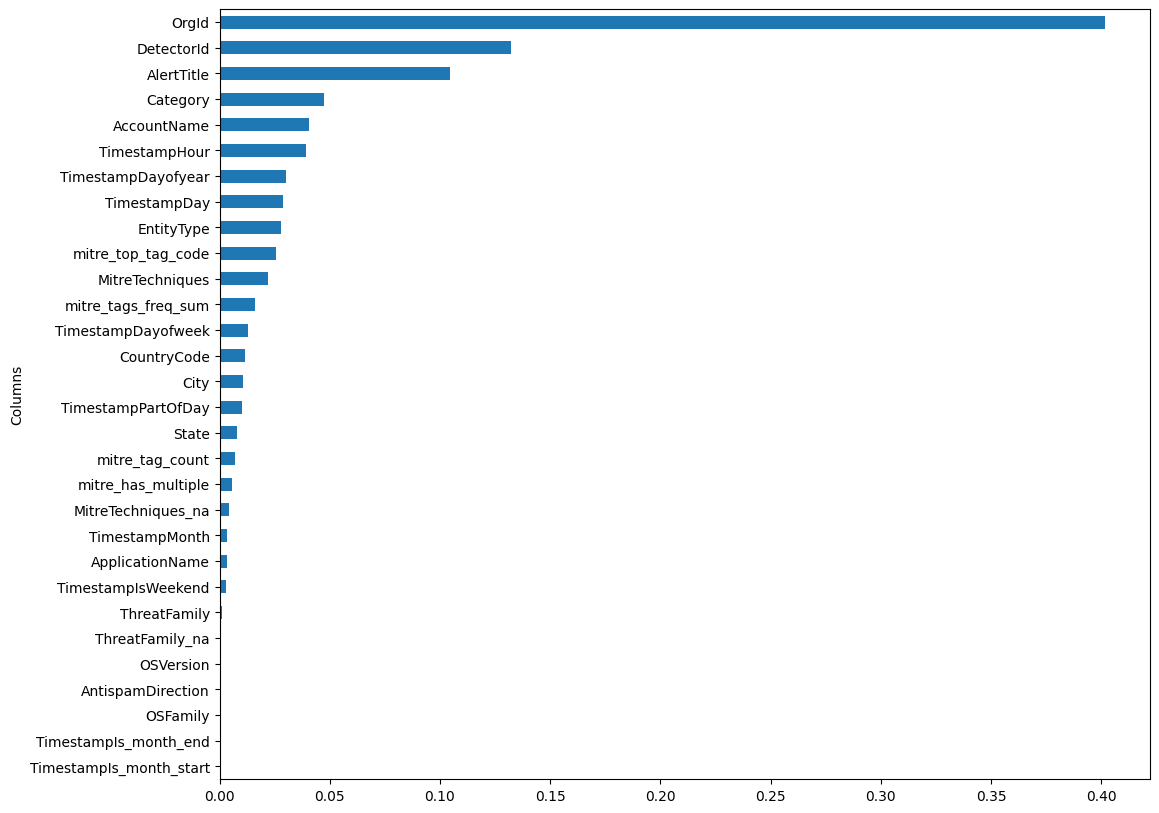

In [13]:
feat_importance = pd.DataFrame({
        'Columns': X_train.columns.tolist(), 
        'Importance': classifier.feature_importances_
})
feat_importance.sort_values('Importance', ascending = False, inplace = True)

barh = feat_importance[:30].plot('Columns', 'Importance', 'barh',
                                figsize = (12,10), legend = False)
barh = barh.invert_yaxis()
barh

<a id="firstbiginterpret3"></a>

### Interpretation of the results we obtained. Part III

Here we can see the feature importances. Unfortunately, for a huge dataset like this it is impossible to get `permutation importances` on my machine with 16GB of RAM. Nevertheless, I can admit that my suggestion was correct: there can be a specific-company model. Top1 and top2 features are exactly OrgId and DetectorId. This means, that having this model for a stable immutable set of detectors and companies will have a very discriminant result in terms of grade identification.

To conclude, our first model classifies very well, though it is quite specific. Let me move for the next part where we will try a more general model.

In [14]:
with open(models_path / 'RF_specific.pk', 'wb') as file:
    dill.dump(classifier, file)

<a id="secondmodel"></a>

## General model

In this section we will try to build the best ML model without `OrgId` and `DetectorId` columns. So, let me drop them:

In [15]:
df_train.drop(columns=['OrgId', 'DetectorId'], inplace=True)
df_test.drop(columns=['OrgId', 'DetectorId'], inplace=True)

In [16]:
small_sample_tr = df_train.sample(100_000, random_state=42)
small_sample_tst = df_test.sample(100_000, random_state=42)
X_train = small_sample_tr.drop(columns=['IncidentGrade'])
y_train = small_sample_tr['IncidentGrade']
X_test = small_sample_tst.drop(columns=['IncidentGrade'])
y_test = small_sample_tst['IncidentGrade']

<a id="secondstudiesrf"></a>

### RandomForestClassifier optuna study on a sample of `100_000`

As usual, we will not rush into fitting the whole dataset at once. To precise, until the very end of this section we will not have a fully-fitted dataset as I do not have enough RAM for this. 

For hyper-parameter tuning of the RandomForestClassifier I chose to use optuna study instead of GridSearchCV. One point that I am missing is nested cross-validation to prevent overfitting, and here are the reasons why:
  1. The computations themselves already cost a lot, so I cannot add nested cross-validation physically.
  2. We are not that worried about overfitting in exactly this case as the sample is many times smaller than the resulting fitted dataset.

Performance is evaluated on a 100_000 sample from the test set, metric is F1-macro score. Beneath you can observe a function with hyper-parameters I decided to tune:

[Back to top](#plan)

In [17]:
def rf_obj(trial, X_training, y_training, X_validation, y_validation):
    estim = trial.suggest_int("n_estimators", 5, 700, log=False)
    min_decrease = trial.suggest_float("min_impurity_decrease",
                                        1e-10, 1e-3, log=True)
    depth = trial.suggest_int("max_depth", 30, 200, log=False)
    min_split = trial.suggest_int("min_samples_split", 5, 15, log=False)
    features = trial.suggest_categorical("max_features", [None, 'sqrt', 'log2'])
    weights = trial.suggest_categorical("class_weight", [None, 'balanced'])
    
    model = RandomForestClassifier(
        n_estimators=estim,
        criterion='gini',
        max_depth=depth,
        min_samples_split=min_split,
        max_features=features,
        min_impurity_decrease=min_decrease,
        class_weight=weights,
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_training, y_training)
    
    y_pred_validation = model.predict(X_validation)
    f1_macro = f1_score(y_validation, y_pred_validation,
                                average='macro')
    return f1_macro

In [18]:
study = optuna.create_study(study_name="rf_opt", 
                            load_if_exists=True, 
                            storage = "sqlite:///opt.db",
                            direction="maximize")

#study.optimize(lambda trial: rf_obj(trial, X_train, y_train, X_test, y_test), n_trials=200, show_progress_bar=True)

[I 2025-12-07 01:19:57,822] Using an existing study with name 'rf_opt' instead of creating a new one.


<a id="secondstudiesxgb"></a>

### XGBClassifier optuna study on a sample of `100_000`

`Note: the training is performed on a cuda device`


A similar in terms of evaluation to the previous one is the next study: XGBClassifier optuna study.
Beneath you can observe a function with hyper-parameters I decided to tune:

[Back to top](#plan)

In [19]:
def xgb_opt(trial, X_training, y_training, X_validation, y_validation):
    lr_guess = trial.suggest_float("learning_rate", 1e-3, 0.5, log=True)
    md_guess = trial.suggest_int("max_depth", 30, 1000, log=False)
    mcw_guess = trial.suggest_int("min_child_weight", 1, 1000, log=False)
    subspl_guess = trial.suggest_float("subsample", 0.7, 1, log=False)
    colspl_guess = trial.suggest_float("colsample_bytree", 0.7, 1, log=False)
    est_guess = trial.suggest_int("n_estimators", 5, 700, log=False)
    
    model = XGBClassifier(
        device='cuda',
        n_estimators=est_guess,
        learning_rate=lr_guess,
        max_depth=md_guess,
        min_child_weight=mcw_guess,
        subsample=subspl_guess,
        colsample_bytree=colspl_guess,
        random_state=42
    )
    
    model.fit(X_training, y_training)
    
    y_pred_validation = model.predict(X_validation)
    f1_macro = f1_score(y_validation, y_pred_validation, average='macro')
    return f1_macro

In [20]:
study = optuna.create_study(study_name="xgb_opt", 
                            load_if_exists=True, 
                            storage = "sqlite:///opt.db",
                            direction="maximize")

#study.optimize(lambda trial: xgb_opt(trial, X_train, y_train, X_test, y_test), n_trials=200, show_progress_bar=True)

[I 2025-12-07 01:19:57,888] Using an existing study with name 'xgb_opt' instead of creating a new one.


<a id="secondstudiescatb"></a>

### CatBoostClassifier optuna study on a sample of `100_000`

`Note: the training is performed on a GPU device`

Evaluation metrics are the same. CatBoostClassifier does not need any preprocessing, but my dataset is:
  1. Very large
  2. Has missing target values
  3. Has a datetime column

Therefore I created a function for preprocessing the raw dataset (you can find it in src/prepcatboosting.py called ready2catboost), and did it outside of this notebook. What I obtained from there is in 2 files: catb_test.feather and catb_train.feather. I open them in the next cell to create a CatBoost Pool object.
Beneath you can observe a function with hyper-parameters I decided to tune:

[Back to top](#plan)

In [21]:
train_data = pd.read_feather(data_path / 'catb_train.feather')
eval_data = pd.read_feather(data_path / 'catb_test.feather')
cat_features = train_data.select_dtypes(include=['object', 'category']).columns
cat_features = cat_features[~cat_features.isin(['IncidentGrade'])].tolist()
train_data, eval_data, y_test = pcat.toPool(train_data, eval_data,
                                            'IncidentGrade', cat_features)

In [22]:
def catb_opt(trial, train_data, eval_data, y_validation):
    learning_rate_guess = trial.suggest_float("learning_rate",
                                                1e-3, 0.5, log=True)
    max_depth_guess = trial.suggest_int("max_depth", 4, 13, log=False)
    iter_guess = trial.suggest_int("iterations", 500, 3000, log=False)
    reg_guess = trial.suggest_int("reg_lambda", 2, 10, log=False)
    earl_sr_guess = trial.suggest_int("early_stopping_rounds",
                                        30, 150, log=False)
    
    model = CatBoostClassifier(
        task_type='GPU',
        devices='0',
        gpu_ram_part=0.8,
        random_seed=42,
        loss_function='MultiClass',
        eval_metric='TotalF1',
        iterations=iter_guess,
        learning_rate=learning_rate_guess,
        reg_lambda=reg_guess,
        max_depth=max_depth_guess,
        use_best_model=True,
        early_stopping_rounds=earl_sr_guess
    )
    
    model.fit(train_data, eval_set=eval_data)
    
    y_pred_validation = model.predict(eval_data, prediction_type='Class')
    f1_macro = f1_score(y_validation, y_pred_validation,
                                average='macro')
    return f1_macro

In [23]:
study = optuna.create_study(study_name="catboost_opt", 
                            load_if_exists=True, 
                            storage = "sqlite:///opt.db",
                            direction="maximize")

#study.optimize(lambda trial: catb_opt(trial, train_data, eval_data, y_test), n_trials=200, show_progress_bar=True)

[I 2025-12-07 01:20:13,694] Using an existing study with name 'catboost_opt' instead of creating a new one.


<a id="secondstudiesres"></a>

### Results of the studies

All results you can check at the dashboard running `optuna-dashboard sqlite:///opt.db` in the terminal.

Shortly:
1. XGBClassifier best result: 0.9622197074061373
2. RandomForestClassifier best result: 0.9481644734944729
3. CatBoostClassifier best result: 0.7119751585576343

Further I will use two best-performance models: XGBClassifier (also XGBoost without wrapper) and RandomForestClassifier

<a id="secondmodelbestxgb"></a>

### Best model I cross-validation: XGBClassifier

`Note: the training is performed on a cuda device`

The parameters for our best XGBClassifier are:
- learning_rate: 0.14385554221431152
- max_depth: 579
- min_child_weight: 1
- subsample: 0.7002921854987602
- colsample_bytree: 0.7312785217434753
- n_estimators: 366

Now let me perform on a 100_000 sample cross-validation to understand how much do we overfit

[Back to top](#plan)

In [24]:
train_sample = df_train.sample(n=100_000, random_state=42)
test_sample = df_test.sample(n=100_000, random_state=42)
X_train = train_sample.drop(columns=['IncidentGrade'])
y_train = train_sample['IncidentGrade']
X_test = test_sample.drop(columns=['IncidentGrade'])
y_test = test_sample['IncidentGrade']

In [25]:
model = XGBClassifier(
        device='cuda',
        n_estimators=366,
        learning_rate=0.14385554221431152,
        max_depth=579,
        min_child_weight=1,
        subsample=0.7002921854987602,
        colsample_bytree=0.7312785217434753,
        random_state=42
    )

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_score = cross_val_score(estimator=model, X=X_train,
                        y=y_train, scoring='f1_macro', cv=kf, n_jobs=-1)

print(f'Cross-validation score: {cv_score.mean()}')

Cross-validation score: 0.7267604854153313


In [26]:
%time model.fit(X_train, y_train)

CPU times: total: 1min 1s
Wall time: 1min 2s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7312785217434753, device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.14385554221431152,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=579, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=366, n_jobs=None,
              num_parallel_tree=None, ...)

In [27]:
y_pred = model.predict(X_test)

Accuracy Score: 0.9639

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     21519
           1       0.96      0.98      0.97     43601
           2       0.97      0.96      0.96     34880

    accuracy                           0.96    100000
   macro avg       0.97      0.96      0.96    100000
weighted avg       0.96      0.96      0.96    100000



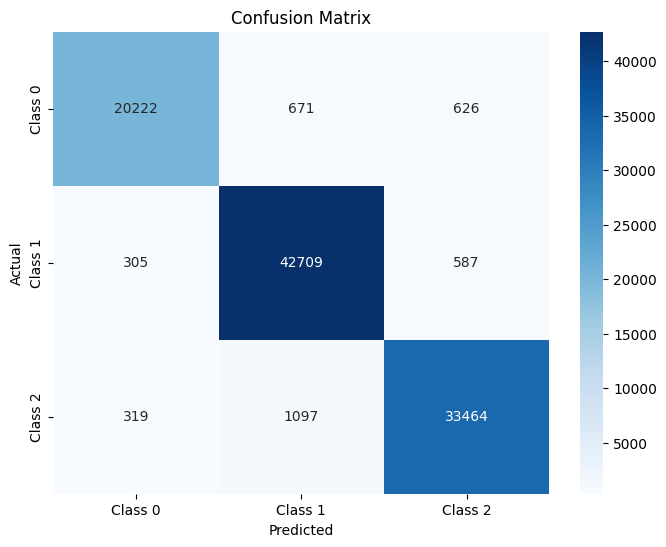

In [28]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<a id="secondmodelbestxgbres"></a>

### Best model I CV results

As we can see, mean cross-validation score is 0.73 (F1-macro), while the score on the test set is 0.96 (F1-macro). I can say from this that our model is not overfitted definitely, but the difference in scores is significant: 0.26 points. Here are the possible problems:
1. We have a very "lucky" random_state
2. Our test set is very simple in comparison with the training set
3. Folds in cross-validation are not balanced well
4. All the data points might be significant for the model (0.73 surprisingly resembles that we split in 5 folds, seeing 0.8 of data in training)
5. This comes from point 4: not only the each data point is significant, but speaking in terms of statistics test and tain data are of the same distribution.

To address this set of problems, I created a section beneath where we will figure out what our problem is. Having (1) as a problem means that the results will change and fix with a different random_state (means CV and test will be same or CV will be higher). Having (2) and (3) can be fixed through changing the amount of data for cross validation along with random_state. The last two problems: (4) and (5) - hold if there is no improvement after all fixes.

Let me first do cross-validation on the second best model RandomForestClassifier:

<a id="secondmodelbestrf"></a>

### Best model II cross-validation: RandomForestClassifier

The parameters for our best RandomForestClassifier are:
- n_estimators: 660
- min_impurity_decrease: 1.0571857779567892e-08
- max_depth: 93
- min_samples_split: 5
- max_features: None
- class_weight: balanced

The sample holds: 100_000 instances

[Back to top](#plan)

In [29]:
model2 = RandomForestClassifier(
    n_estimators=660,
    criterion='gini',
    max_depth=93,
    min_samples_split=5,
    max_features=None,
    min_impurity_decrease=1.0571857779567892e-08,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_score = cross_val_score(estimator=model2, X=X_train,
                        y=y_train, scoring='f1_macro', cv=kf, n_jobs=-1)

print(f'Cross-validation score: {cv_score.mean()}')

Cross-validation score: 0.748212776030536


In [30]:
%time model2.fit(X_train, y_train)

CPU times: total: 5min 19s
Wall time: 43.2 s


RandomForestClassifier(class_weight='balanced', max_depth=93, max_features=None,
                       min_impurity_decrease=1.0571857779567892e-08,
                       min_samples_split=5, n_estimators=660, n_jobs=-1,
                       random_state=42)

In [31]:
y_pred2 = model2.predict(X_test)

Accuracy Score: 0.9506

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94     21519
           1       0.96      0.96      0.96     43601
           2       0.96      0.94      0.95     34880

    accuracy                           0.95    100000
   macro avg       0.95      0.95      0.95    100000
weighted avg       0.95      0.95      0.95    100000



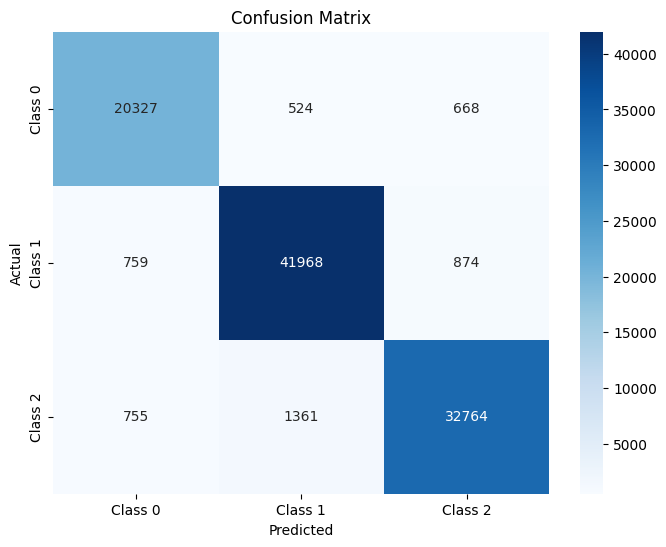

In [32]:
accuracy = accuracy_score(y_test, y_pred2)
print(f"Accuracy Score: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred2))

matrix = confusion_matrix(y_test, y_pred2)

plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<a id="secondmodelbestrfres"></a>

### Best model II CV results

The problem is of the same kind as with XGBClassifier. Before we try to fix it, let`s simply change the random_state and see if anything changes:

[Back to top](#plan)

In [ ]:
test_sample = df_test.sample(n=100_000, random_state=0) # I change random_state here to have another sample of testing data
X_test = test_sample.drop(columns=['IncidentGrade'])
y_test = test_sample['IncidentGrade']
y_pred = model.predict(X_test)
y_pred2 = model2.predict(X_test)

In [34]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy Score: 0.7529

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.59      0.64     21503
           1       0.75      0.83      0.79     43548
           2       0.79      0.76      0.77     34949

    accuracy                           0.75    100000
   macro avg       0.75      0.73      0.73    100000
weighted avg       0.75      0.75      0.75    100000



In [35]:
accuracy = accuracy_score(y_test, y_pred2)
print(f"Accuracy Score: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred2))

Accuracy Score: 0.7711

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.64      0.67     21503
           1       0.77      0.84      0.80     43548
           2       0.81      0.76      0.79     34949

    accuracy                           0.77    100000
   macro avg       0.76      0.75      0.75    100000
weighted avg       0.77      0.77      0.77    100000



<a id="secondwholesamplecvproblem"></a>

### Whole training sample result interpretation

We see that the result has worsened. This points us exactly to problem 1. Nevertheless, the result holds problem 5: if data has the same structure (distribution), then taking a random_state for testing different from the random_state of the training set will also worsen the score. To address the remaining unsolved problem, I designed cross-validation on different sample sizes with different random_states. At each cross-validation for some sample size the random_state is the same everywhere: otherwise the results will be worse all the time (what we have proved already). If the problem holds here, this will mean that the true problem is in data groups distribution.

Note: sample size was chosen manually, random_state was chosen with the following code

<img src="images_for_ipynb/random_problem.png">

[Back to top](#plan)

In [36]:
gc.collect()

6033

In [ ]:
sample_size = [50_000, 75_000, 100_000, 125_000, 150_000, 175_000,
              200_000, 225_000, 250_000, 275_000, 300_000]
rs = [3, 9, 60, 75, 24, 85, 77, 71, 94, 0, 30]
cv_scores_rp = list()
test_scores_rp = list()

for size, state in tqdm(zip(sample_size, rs), desc='Fitting sample'):
  train_sample = df_train.sample(n=size, random_state=state)
  test_sample = df_test.sample(n=size, random_state=state)
  X_train = train_sample.drop(columns=['IncidentGrade'])
  y_train = train_sample['IncidentGrade']
  X_test = test_sample.drop(columns=['IncidentGrade'])
  y_test = test_sample['IncidentGrade']
  
  kf = KFold(n_splits=5, shuffle=True, random_state=state)
  cv_score = cross_val_score(estimator=model, X=X_train,
                          y=y_train, scoring='f1_macro', cv=kf, n_jobs=-1)
  
  model.fit(X_train, y_train)
  predictions = model.predict(X_test)
  f1_sample = f1_score(y_test, predictions, average='macro')
  
  cv_scores_rp.append(cv_score.mean())
  test_scores_rp.append(f1_sample)

Fitting sample: 11it [2:05:50, 686.45s/it]

Mean score on cv: 0.000000%, mean score on test set:0.00%


Mean score on cv: 0.7370936490127431, mean score on test set: 0.9548159378783942

In [38]:
print('CV scores:', cv_scores_rp)
print('Test set scores:', test_scores_rp)

CV scores: [np.float64(0.7063965848821226), np.float64(0.7200258563214158), np.float64(0.7297164511127712), np.float64(0.7347533618895711), np.float64(0.7374388563050892), np.float64(0.7415823769707544), np.float64(0.7444994996530332), np.float64(0.743826659224618), np.float64(0.7469692774471106), np.float64(0.750696761944934), np.float64(0.7521244533887539)]
Test set scores: [0.9727788886039178, 0.9673842419342892, 0.9620449962074457, 0.9588111193334544, 0.9551052406777351, 0.9530342495996552, 0.9514875482661252, 0.9478313789316314, 0.9462465643834895, 0.9451420742471979, 0.9431090144773955]


In [39]:
predictions = model.predict(X_train)
print('Score on full training sample for the last model:',
      f1_score(y_train, predictions, average='macro'))

Score on full training sample for the last model: 0.9431090144773955


<a id="secondwholesamplecvproblemconclusion"></a>

### Conclusion on the nature of training and testing datasets.

For different sizes and random_states the problem is always the same: CV highly underperforms testing results, on average by 0.22 points. This means that eventually problem (1) is not true. Moreover, as I noticed in problems 4 and 5, the mean CV score highly resembles the number of splits (5 splits, and mean overall CV score is 0.74). But these all are just markers of problem 5. The resulting, and most important one, is the previous executed sell: score on the last train set of size 300_000 with random seed 30 is `exactly` the same as the score on the last testing set of size 300_000 with random seed 30. This means that we are working with testing and training datasets of the same distribution: we chose 300_000 points in the same way and got absolutely identical results on both (0.9431090144773955). Having one result on the train set will mean having the same result on the testing set. For the moment, we cannot do anything with this: the split and the challenge was created by Microsoft. Whether it is a problem or not, the question should be addressed to a SOC-analytic. I do not know if this is actually a problem. I will then proceed with this in mind, but this will not affect the code.  

<a id="secondstudiesxgb3m"></a>

### XGBClassifier on a sample of 3_000_000 entries

Working on the problem of a general ML model, the final goal is to fit it on the whole dataset. However, it turned out that this is not possible with my RAM capabilities. When we have dropped OrgId and DetectorId columns, it became much harder to differentiate classes, so the computing time has increased along with the RAM load. Multiple times I have encountered computer crashes because of that, which finally resulted into fitting a 3_000_000 sample with XGBClassifier.

An interesting attempt I have made during exploring how could I lower my RAM load was this one:

<img src="images_for_ipynb/buffering_attempt.png">

Here I create two buffering files, so that I can use my ROM as well. Then I do an xgboost.train(), which is basically what underlies XGBClassifier wrapper. The computations are left for a cuda device as usual. The idea is the following: the model takes chunk by chunk information from my ROM, so that it is not stored in RAM, then processes it, so that I can avoid computer crashes. This attempt was nice as for a long period of time the computer managed to run without crashes. But, as you have already understood, eventually I had a crush. Impossibility of training on the whole dataset led me to fitting only a 3M sample.

Now lets fit the model and have a look at the results. The parameters are the same obtained from the optuna study.

[Back to top](#plan)

In [40]:
gc.collect()

100

In [41]:
train_sample = df_train.sample(n=3_000_000, random_state=42)
test_sample = df_test.sample(n=3_000_000, random_state=42)
X_train = train_sample.drop(columns=['IncidentGrade'])
y_train = train_sample['IncidentGrade']
X_test = test_sample.drop(columns=['IncidentGrade'])
y_test = test_sample['IncidentGrade']

model = XGBClassifier(
        device='cuda',
        n_estimators=366,
        learning_rate=0.14385554221431152,
        max_depth=579,
        min_child_weight=1,
        subsample=0.7002921854987602,
        colsample_bytree=0.7312785217434753,
        random_state=42
    )

%time model.fit(X_train, y_train)

CPU times: total: 18min 59s
Wall time: 23min 57s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7312785217434753, device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.14385554221431152,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=579, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=366, n_jobs=None,
              num_parallel_tree=None, ...)

In [42]:
gc.collect()

28

In [43]:
y_pred = model.predict(X_test)

Accuracy Score: 0.9079

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88    643431
           1       0.89      0.95      0.92   1307320
           2       0.93      0.89      0.91   1049249

    accuracy                           0.91   3000000
   macro avg       0.91      0.90      0.90   3000000
weighted avg       0.91      0.91      0.91   3000000



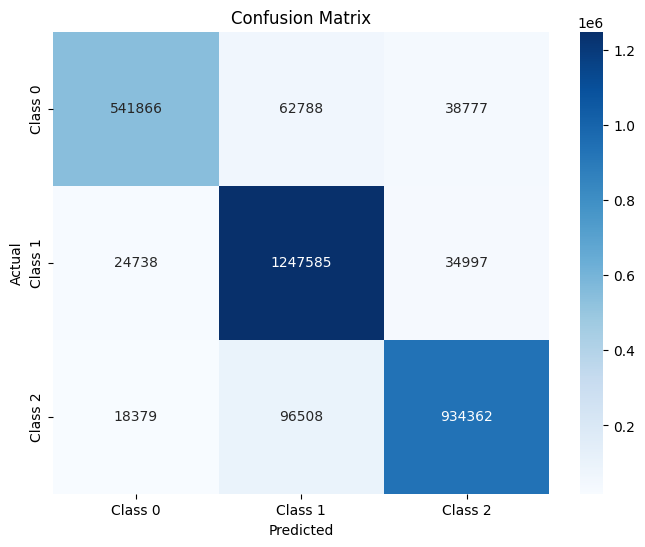

In [44]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<a id="second3mres1"></a>

### General model: results I

The performance has decreased by 10% in comparison with the company specific model. I suppose, that fitting the whole dataset will make F1-score converge at around 0.9. In terms of cybersecurity, 0.9 is rather good than bad, however, companies would probably like a stronger result as digital infrastructure safety is crucial nowadays. In my opinion, having such a result after dropping discriminatory columns of OrgId and DetectorId is impressive. Moreover, what I would like to point out from the confusion matrix, Class 1 is the most frequently missed (BP). It is definitely not good, but the important thing here is that we miss Class 2 (TP) `much` less. It is always better to have a "False" attack then a "True" one. Missing Class 2 less means that there is a lower chance of taking a huge infrastructure and reputational hit, whereas missing Class 1 more means just a bigger workload for a SOC-analyst, not a "breaking news section".  

[Back to top](#plan)

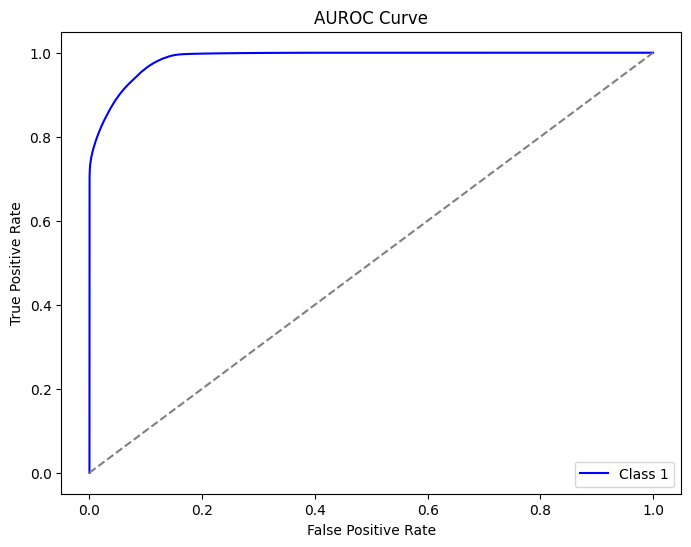

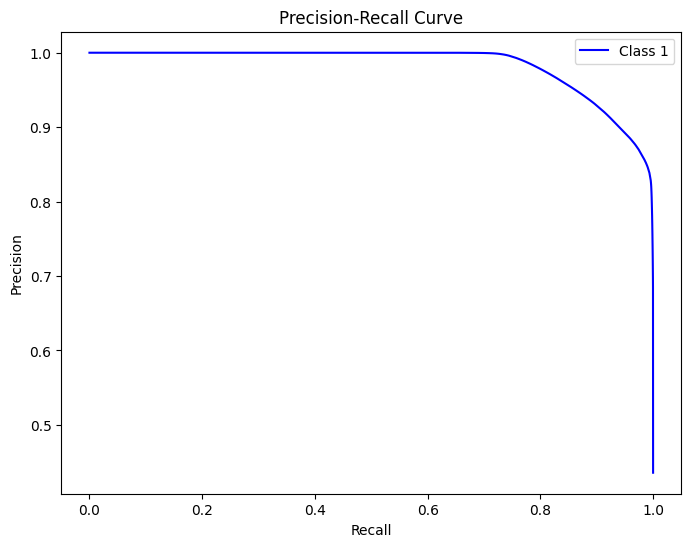

In [45]:
y_prob = model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1], pos_label=1)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label='Class 1')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("AUROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_prob[:, 1], pos_label=1)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label='Class 1')
plt.title("Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

<a id="second3mres2"></a>

### General model: results II

For the sake of interest I plotted exactly the same curves as in the specific model. They already do not look "perfect", but still "excellent" 

[Back to top](#plan)

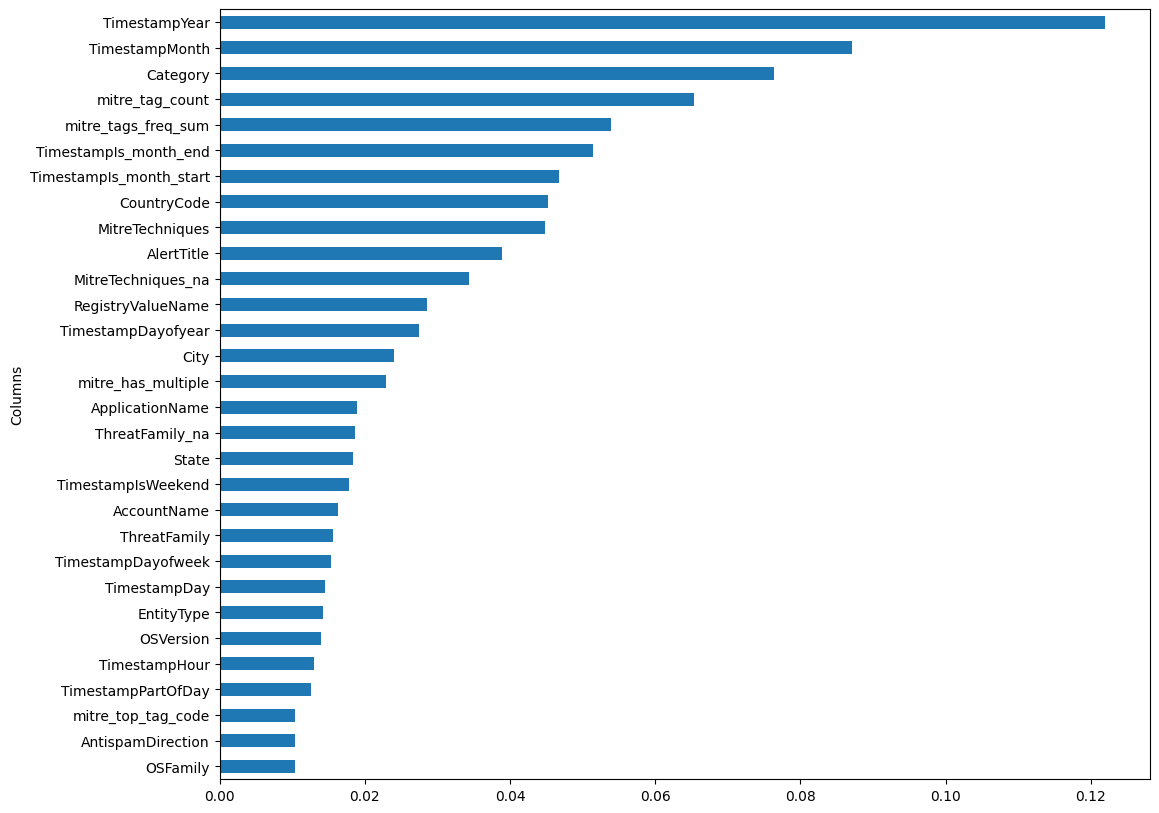

In [46]:
feat_importance = pd.DataFrame({
        'Columns': X_train.columns, 
        'Importance': model.feature_importances_
})
feat_importance.sort_values('Importance', ascending = False, inplace = True)

barh = feat_importance[:30].plot('Columns', 'Importance', 'barh',
                                        figsize = (12,10), legend = False)
barh = barh.invert_yaxis()
barh

<a id="second3mres3"></a>

### General model: results III

From the feature importances we can notice that 6 out of top-10 features are made in the preprocessing section by me. I want to make a small reminder here that we still do not have a possibility to make permutation importances. The result of feature engineering is good. New columns make a big difference in the resulting model. Also, I would like to note that 4 of the feature engineered columns have an influence less than 0.01, and neither of the rest columns are there. That 4 columns derive from engineering a datetime column. Still, having Year and Month columns as the most discriminatory ones gives a lot of questions about the results. In my sense, Year can be a mapper to the amount of attacks, for example, with the Internet spread and more people coming as actors there could be more hackers/techniques to attack, but the studies observe only the end of one year and the start of another (around 1 month timeline), and the Month column gives no sense in terms of the amount of attacks and classification. These things should be discussed with a professional, and my amateur suggestion is that the found pattern at least with the Month column is wrong.

In [49]:
model.get_booster().save_model(
    models_path / 'XGB_general.json'
)

<a id="bottom"></a>
[Back to top](#plan)